# Image Segmentation with PyTorch 
### (Inference only)

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as transforms_f

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import numpy as np
import cv2

import matplotlib.pyplot as plt

from coco_category_names import inst_classes, idx_to_classname

# Models
* RCNN (Region Based Convolutional Neural Network)
* Fast RCNN
* Faster RCNN
* https://developers.arcgis.com/python/guide/faster-rcnn-object-detector/
* * Mask RCNN (Segmentation)
* * Keypoint RCNN (Human pose estimation)
* SSD (Single shot detector)
* YOLO (You only look once)

## Mask RCNN
* Image segmentation model (can also do object detection)
* Backbone layers trained in Imagenet
* Rest trained in COCO 2017
* Outputs detected segmentation mask, object coordinates, classes and scores
* Segmentation mask: Predicted segmentation of each class
* Object coordinates: xmin, ymix, xmax, ymax (bounding box)
* Classes: COCO annotation categories (person, car, dog etc.)
* https://pytorch.org/vision/master/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html
* Full paper: https://arxiv.org/pdf/1703.06870.pdf

In [2]:
# Pretrained model (with Imagenet and COCO 2017)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# Models have two modes: training and evaluation
# It is important to switch model into evaluation mode for inference
model = model.eval()

print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/lecturer/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Total trainable parameters: 44,178,993


### RoI (region of interest) Prediction layers

In [3]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (mask_fcn1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (mask_fcn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (mask_fcn3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (mask_fcn4): Conv2d(256, 256, kern

### Open and plot an example image

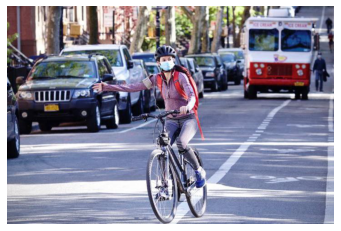

In [4]:
full_image_path = '../test_images/bicycle3.jpg'
#full_image_path = 'agriculture_images/tarla3.jpg'
image_raw = Image.open(full_image_path).convert('RGB')
plt.axis('off')
plt.imshow(image_raw)

### PyTorch deep learning models expect a tensor as input

In [5]:
# Convert raw image to tensor
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
img_transforms = transforms.Compose([
    transforms.ToTensor(),
])

### Add batch dimension (models expect it)
### (C, H, W) -> (N, C, H, W)

In [6]:
# Use .unsqueeze(0) to add dummy batch dimension
image_tensor = img_transforms(image_raw).unsqueeze(0)
image_tensor.shape

torch.Size([1, 3, 478, 718])

### Make prediction with pretrained model

In [7]:
predictions = model(image_tensor)
len(predictions)

/Users/lecturer/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1

### Model predicts:
* Boxes: bounding box covering the object (xmin, ymix, xmax, ymax)
* Labels: which class (category) it belongs to (see COCO annotation categories)
* Scores: Prediction confidence for each predicted category and bounding box
* Masks: Predicted segmentation masks (2D, similar to an image)

In [8]:
#predictions[0]

In [9]:
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [10]:
all_boxes = predictions[0]['boxes']
all_labels = predictions[0]['labels']
all_scores = predictions[0]['scores']
all_masks = predictions[0]['masks']

In [11]:
all_masks.shape

torch.Size([57, 1, 478, 718])

### Select high confidence (score) predictions

In [12]:
threshold = 0.8
high_confidence_indexes = torch.where(all_scores > threshold)
high_confidence_indexes

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),)

In [13]:
high_confidence_boxes = all_boxes[high_confidence_indexes]
#high_confidence_boxes

In [14]:
high_confidence_labels = all_labels[high_confidence_indexes]
#high_confidence_labels.tolist()

In [15]:
high_confidence_masks = all_masks[high_confidence_indexes]
#high_confidence_masks

In [16]:
high_confidence_labels_str = [idx_to_classname[idx] for idx in high_confidence_labels.tolist()]

## Plot bounding boxes on top of the input image
#### draw_bounding_boxes: torchvision utility function (works with tensors)

In [17]:
img_with_boxes = draw_bounding_boxes(
    read_image(full_image_path), 
    high_confidence_boxes, 
    labels=high_confidence_labels_str,
    colors=['blue']*len(high_confidence_boxes), 
    width=4
)

#### Note that function returns tensors as well, you need to convert back to raw image (numpy array) for matplotlib

In [18]:
img_with_boxes = img_with_boxes.detach()
img_with_boxes = transforms_f.to_pil_image(img_with_boxes)

Total objects found: 11


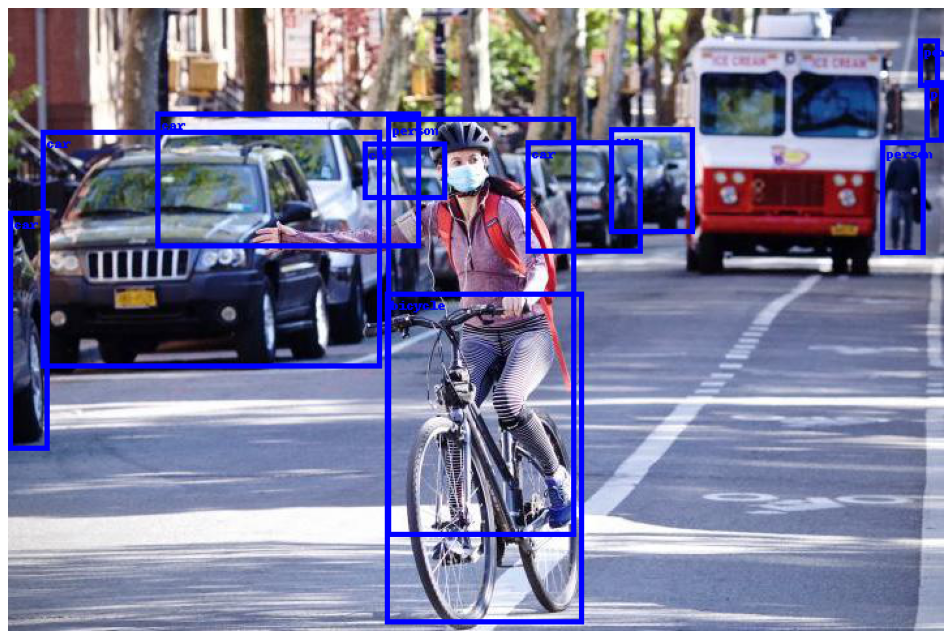

In [19]:
print('Total objects found:', len(high_confidence_labels))
plt.figure(figsize=(12, 12), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(np.asarray(img_with_boxes))

## Plot segmentation masks

In [20]:
print('Total masks:', len(high_confidence_masks))

Total masks: 11


### Note that segmentation masks can be plotted like an image

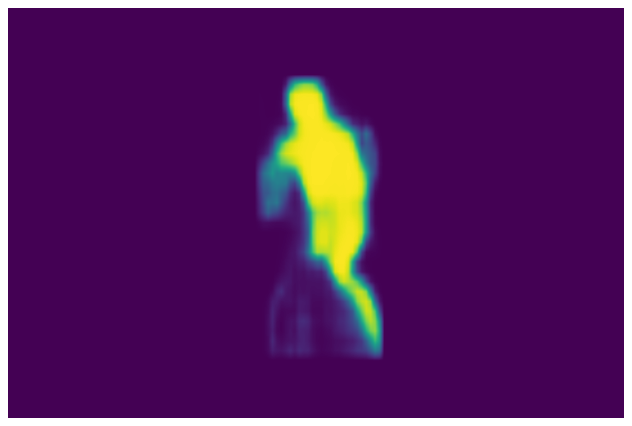

In [21]:
# Select one of the predicted masks
MASK_ID = 0
segmentation_mask = high_confidence_masks[MASK_ID].detach()
segmentation_mask = transforms_f.to_pil_image(segmentation_mask)

plt.figure(figsize=(8, 8), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(np.asarray(segmentation_mask))

## Single Mask on top of the image

(478, 718, 3)
(478, 718, 3)


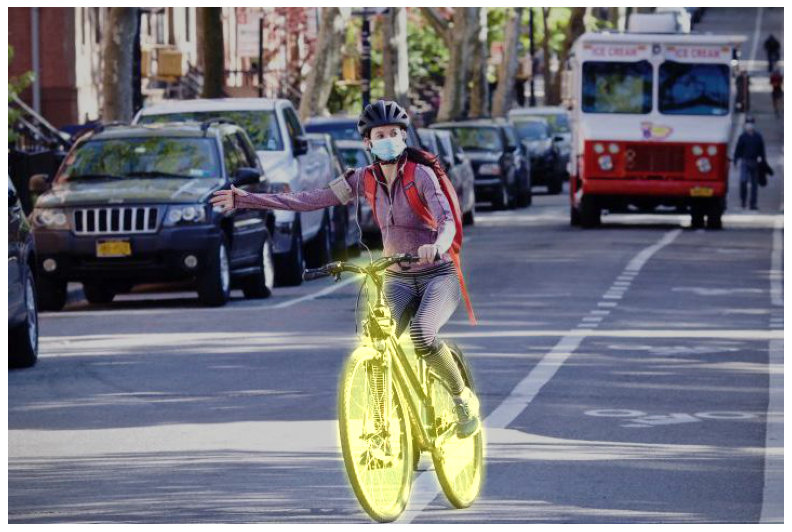

In [22]:
# color to fill
color = np.array([255, 255, 0], dtype='uint8')

# equal color where mask, else image
# this would paint your object silhouette entirely with `color`
MASK_ID = 2
segmentation_mask = high_confidence_masks[MASK_ID].detach().numpy()
#image_numpy = np.array(image_raw).reshape(1, *image_numpy.shape)
image_numpy = np.array(image_raw)

masked_img = np.where(segmentation_mask[..., None], color, image_numpy)[0]

# TODO: for some reason segmentation_mask has an extra dimension
masked_img[:, :, 0] = masked_img[:, :, 0] * segmentation_mask[0]
masked_img[:, :, 1] = masked_img[:, :, 1] * segmentation_mask[0]
masked_img[:, :, 2] = masked_img[:, :, 2] * segmentation_mask[0]

print(masked_img.shape)
print(image_numpy.shape)

# use `addWeighted` to blend the two images
# the object will be tinted toward `color`
out = cv2.addWeighted(image_numpy, 0.8, masked_img, 0.5, 0)

plt.figure(figsize=(10, 10), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(out)

## All Masks on top of the image

In [23]:
# this would paint your object silhouette entirely with `color`

#image_numpy = np.array(image_raw).reshape(1, *image_numpy.shape)
image_numpy = np.array(image_raw)

for MASK_ID in range(len(high_confidence_masks)):
    segmentation_mask = high_confidence_masks[MASK_ID].detach().numpy()
    masked_img = np.where(segmentation_mask[..., None], color, image_numpy)[0]

    # TODO: for some reason segmentation_mask has an extra dimension
    masked_img[:, :, 0] = masked_img[:, :, 0] * segmentation_mask[0]
    masked_img[:, :, 1] = masked_img[:, :, 1] * segmentation_mask[0]
    masked_img[:, :, 2] = masked_img[:, :, 2] * segmentation_mask[0]

    # use `addWeighted` to blend the two images
    # the object will be tinted toward `color`
    image_numpy = cv2.addWeighted(image_numpy, 1.0, masked_img, 0.4, 0)

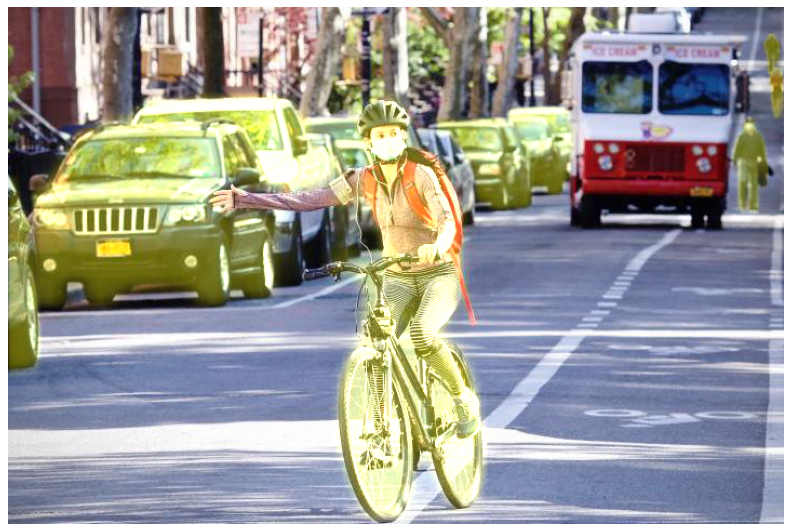

In [24]:
plt.figure(figsize=(10, 10), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(image_numpy)

# Video frames

In [25]:
def show_segmentation_masks(image, annotations, color, confidence_threshold=None):
    """
    image: image tensor
    annotations: dictionary containing annotations (bbox, labels, etc.)
    confidence_threshold: prediction confidence (between 0.0-1.0)
    """
    # H, W, C -> C, H, W
    #mg_copy = np.array(image.permute(1, 2, 0).numpy().copy())
    img_copy = image
    all_boxes = annotations['boxes']
    all_labels = annotations['labels']
    all_masks = annotations['masks']


    if confidence_threshold:
        # Select predictions above the threshold
        all_scores = annotations['scores']
        high_confidence_idx = torch.where(all_scores>=confidence_threshold)
        all_boxes = all_boxes[high_confidence_idx]
        all_labels = all_labels[high_confidence_idx]
        all_masks = all_masks[high_confidence_idx]
        
        
    for MASK_ID in range(len(all_masks)):
        segmentation_mask = all_masks[MASK_ID].detach().cpu().numpy()
        masked_img = np.where(segmentation_mask[..., None], color, img_copy)[0]

        # TODO: for some reason segmentation_mask has an extra dimension
        masked_img[:, :, 0] = masked_img[:, :, 0] * segmentation_mask[0]
        masked_img[:, :, 1] = masked_img[:, :, 1] * segmentation_mask[0]
        masked_img[:, :, 2] = masked_img[:, :, 2] * segmentation_mask[0]

        img_copy = cv2.addWeighted(img_copy, 1.0, masked_img, 0.6, 0)
    return img_copy